# Pre-Processing Dataset

Here I generate the `gal_fname1` which cointains the columns needed to this study: `Mr, R, R/R200, v_los, v_circ, orbital, infall, interloper`.


In [1]:
from file_loc import FileLocs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
import astropy.table as Table
import astropy.io.ascii as at

# Reading Initial Data

In [3]:
fl = FileLocs()
galaxy_file = fl.gal_fname0
cluster_file= fl.cls_fname

In [4]:
print('--------Initial Files-------')
print('Cluster File : %s'%cluster_file)
print('Galaxy File : %s'%galaxy_file)
print()

--------Initial Files-------
Cluster File : ../data/groupCatalog_Yang_deCarvalho2017.csv
Galaxy File : ../data/groupCatalog_Yang_deCarvalho2017_galaxy.csv



In [5]:
# load catalogs
cat = at.read(cluster_file)
gal0= at.read(galaxy_file)

In [6]:
cat

Yang,RA,DEC,z,logM200,R200,N200
int64,float64,float64,float64,float64,float64,int64
2,240.5602,16.1113,0.036,15.29,2.01,525
4,247.1149,40.8317,0.03,14.66,1.24,217
5,247.1633,39.4674,0.03,14.81,1.4,277
6,167.6936,28.5374,0.033,14.6,1.18,167
7,351.1194,14.6251,0.042,14.51,1.1,106
8,239.5372,27.3133,0.09,15.1,1.71,183
9,241.5673,18.1483,0.038,14.48,1.08,143
10,223.2712,16.724,0.045,14.22,0.89,106
11,10.4693,-9.3997,0.056,14.96,1.55,156


In [7]:
gal0

Yang,objid,specobjid,distance,ra,dec,mu,mg,mr,mi,mz,mu_Err,mg_err,mr_err,mi_err,mz_err,photo_z,photo_zErr,z,zErr,fracDeV_i,bpt,mass,mass_p16,mass_p84,sfr,sfr_p16,sfr_p84,ssfr,ssfr_p16,ssfr_p84,mass_fire,mass_fire_p16,mass_fire_p84,age_fire,age_fire_p16,age_fire_p84,score
int64,int64,str20,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2,1237665530650034690,null,74.1483323128654,241.203003297151,15.0418032201749,19.64536,18.01927,17.27403,16.93712,16.73135,0.1303512,0.0149506,0.01091812,0.01284297,0.03753516,0.083337,0.033269,-99.0,-99.0,0.6659245,null,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.9158974
2,1237665530650101452,null,79.1421483780414,241.343080468772,15.0291128455272,17.71264,19.42489,18.03743,29.79065,17.2319,0.139198,0.2863158,0.1142305,0.3949105,0.3700946,-9999.0,-9999.0,-99.0,-99.0,1.0,null,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.9120452
2,1237665530650230847,null,89.1757237983494,241.572676973232,14.9898837528674,19.20037,17.23652,16.22114,15.80519,15.46211,0.04575067,0.005569477,0.003785835,0.003832662,0.00756976,0.116595,0.007638,-99.0,-99.0,1.0,null,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.9118443
2,1237665530650231112,2841934444107950080,89.6269391362405,241.57843693246,14.9847540670112,20.4757,18.52523,17.54973,17.16701,16.80302,0.0887008,0.009577838,0.006253762,0.006521441,0.01432577,0.110193,0.010211,0.1231728,2.496678e-05,0.9789842,-1,10.69053,10.59839,10.78236,-1.318207,-2.62379,-0.4930567,-12.05,-13.37045,-11.22545,41403010000.0,32091820000.0,53817920000.0,4929381000.0,3280096000.0,6228817000.0,0.9118443
2,1237665530650231189,2841935543619577856,93.0302672496103,241.621146420941,14.9454652864579,19.19824,17.65663,16.8588,16.41705,16.06843,0.05880325,0.008172314,0.005978988,0.006268373,0.01489483,0.077475,0.024489,0.1269354,1.723609e-05,1.0,3,10.99481,10.89298,11.10171,0.6959944,0.2149101,1.181468,-10.34571,-10.85981,-9.835586,19509270000.0,18445930000.0,30142730000.0,3330074000.0,2980226000.0,5729034000.0,0.9118443
2,1237665547827347728,2841891013398652928,66.9279962333088,240.988574304508,15.0749487080488,18.10222,16.55984,15.87389,15.51887,15.23896,0.03046442,0.00452454,0.003532456,0.003606966,0.00795144,0.046343,0.014991,0.03524532,1.029862e-05,0.5167674,1,10.31747,10.22748,10.41237,0.07491233,-0.09746825,0.2819673,-10.28968,-10.48632,-10.06143,6406905000.0,4934299000.0,7745638000.0,8277929000.0,6778579000.0,10976760000.0,0.8717796
2,1237665547827479001,null,81.221857058865,241.293942208227,14.9568518486543,19.89593,18.05669,17.12668,16.65694,16.27435,0.1090162,0.01031303,0.006515275,0.006326848,0.01458072,0.094806,0.023445,-99.0,-99.0,0.1360283,null,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,0.8908026
2,1237665566081483195,2838400888110868480,90.4464881468585,240.713424596535,14.6111162264233,17.71942,16.36608,15.73907,15.40933,15.13747,0.02493478,0.004048082,0.003419265,0.003449163,0.007783792,0.04369,0.012716,0.03736607,1.491802e-05,0.1406163,2,10.13713,10.05175,10.2355,-0.1388986,-0.4566603,0.1964595,-10.32625,-10.65404,-9.982267,2199423000.0,1791245000.0,4881733000.0,3430031000.0,2580399000.0,6528688000.0,0.9467953
2,1237665566081548631,2838401437866682368,88.2947352543135,240.840259513381,14.6647047042551,18.17223,17.28277,16.95842,16.75693,16.56413,0.02911397,0.006809405,0.006163856,0.006861015,0.01980359,0.029663,0.00699,0.03394401,6.543075e-06,0.2055249,1,9.132375,9.061535,9.235763,-0.3468749,-0.5563634,-0.05026153,-9.539729,-9.768909,-9.224825,759437600.0,478372300.0,1142708000.0,3829858000.0,2630377000.0,5828991000.0,0.9464893


# Mask Data

In [112]:
mask = gal0['z']>0.
mask&= (gal0['mass']>0)
mask&= (gal0['sfr']>-99)

Nsize = np.count_nonzero(mask)

print('Masking Galaxies with no redshift or mass estimations')
print('New Size: %i'%(Nsize))
print('fraction: %.2f'%(1.*Nsize/len(gal0)))

Masking Galaxies with no redshift or mass estimations
New Size: 42891
fraction: 0.70


In [113]:
gal = gal0[mask].copy()

In [114]:
def get_percentile_curve(x,y,alpha=5,Npoints=15):
    xbins  = np.percentile(x,np.linspace(0,100,Npoints))
    indices= [(x>=xl)&(x<xh) for xl, xh in zip(xbins[:-1],xbins[1:])]
    ycurve = np.array([np.percentile(y[idx],alpha) for idx in indices])
    return ycurve, 0.5*(xbins[1:]+xbins[:-1])

In [115]:
mass        = np.array(gal['mass'])
zgal        = np.array(gal['z'])
zmask       = (zgal>=0.025)&(zgal<=0.105)
ylow, zbins = get_percentile_curve(zgal[zmask],mass[zmask],Npoints=16)

## Magnitude Limit
---------------------------------------

Definit the mass limit of the study

In [116]:
mass = 10**np.array(gal['mass'])
z    = np.array(gal['z'])

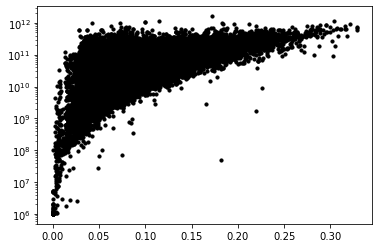

In [117]:
plt.scatter(z,mass,s=10,c='k')
plt.yscale('log')

In [119]:
zlim = (z>0.09)&(z<=0.1)
mass_lim_th = np.log10(np.percentile(mass[zlim],5))
print('Log Stellar Mass Lim: %.3f'%mass_lim_th)

Log Stellar Mass Lim: 10.072


(70000000.0, 900000000000.0)

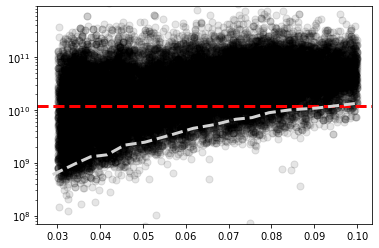

In [120]:
zmask = (z>0.03)&(z<0.1)
plt.scatter(z[zmask],mass[zmask],s=50,alpha=0.1,color='k')
plt.axhline(10**mass_lim_th,ls='--',lw=3,color='r')
plt.plot(zbins,10**ylow ,ls='--',lw=3,color='lightgray')
plt.yscale('log')
plt.ylim(7e7,9e11)

In [121]:
mass_lim = np.interp(gal0['z'],zbins,ylow)
mass_mask = gal0['mass']>=mass_lim
gal = gal0[mask&mass_mask].copy()

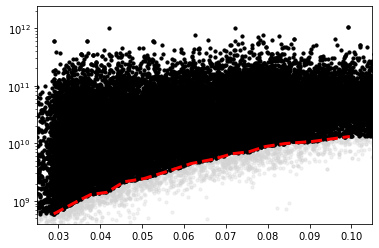

In [132]:
plt.scatter(gal0['z'],10**gal0['mass'],s=10,c='lightgray',alpha=0.3)
plt.scatter(gal['z'],10**gal['mass'],s=10,c='k')
plt.plot(zbins,10**ylow ,ls='--',lw=3,color='r')
plt.xlim(0.025,0.105)
plt.yscale('log')

# Computing new variables
---------------------------------------


In [133]:
import esutil
gcid = np.array(gal['Yang'])
cid  = np.array(cat['Yang'])

key = esutil.numpy_util.match(cid,gcid)

In [134]:
gal['row']      = np.where(mask&mass_mask)[0]
gal['redshift'] = np.zeros(len(gal))
gal['redshift'][key[1]] = cat['z'][key[0]]

gal['M200']    = np.zeros(len(gal))
gal['M200'][key[1]] = cat['logM200'][key[0]]

gal['R200']    = 99.*np.ones(len(gal))
gal['R200'][key[1]] = cat['R200'][key[0]]

## Distance From The Center
---------------------------------------

To have the phase space we need first to compute the distance from the center, $R/R_{200}$.

In [135]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.constants import G, c

cosmo = FlatLambdaCDM(H0=70, Om0=0.283)
Msol = 1.98847e33
Mpc2cm = 3.086e+24
rad2deg= 180/np.pi
h=0.7
c_kms = c.value/1000

def AngularDistance(z):
    DA = float( (cosmo.luminosity_distance(z)/(1+z)**2)/u.Mpc ) # in Mpc
    return DA
AngularDistance = np.vectorize(AngularDistance)

#--- Critical universe density
def rhoc(z):
    try:
        rho_c = float(cosmo.critical_density(z)/(u.g/u.cm**3)) # in g/cm**3
    except:
        rho_c = [float(cosmo.critical_density(zi)/(u.g/u.cm**3)) for zi in z]
        rho_c = np.array(rho_c)
    
    rho_c = rho_c*(Mpc2cm**3)/Msol # in Msol/Mpc**3
    return rho_c

In [136]:
#DA = AngularDistance(zcls)
def convertDegreeToMpc(theta,z):
    da     = AngularDistance(z)
    length = (theta*np.pi/180)*da
    return length

def convertR200toM200(R200,z, nc=200):
    ## M200 in solar masses
    ## R200 in Mpc
    rho = rhoc(z)
    M200 = nc*4*np.pi*rho*R200**3/3
    return M200

In [137]:
gal['R'] = convertDegreeToMpc(gal['distance']/60.,gal['redshift'])
gal['Rn']= gal['R']/gal['R200']

Text(0.5, 0, '$R/R_{200}$')

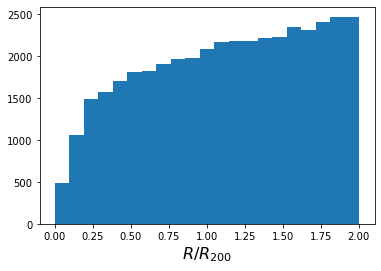

In [138]:
plt.hist(gal['Rn'],bins=21)
plt.xlabel(r'$R/R_{200}$',fontsize=16)

The line of sight velocity
---------------------------------------


Here we compute the line of sight velocity assuming the redshift given by the Yang catalog. For the orbital classification we also need to compute the cluster circular velocity.

In [139]:
def get_los_velocity(z_gal,z_BCG):
    return c_kms*(z_gal - z_BCG)/(1 + z_BCG)

In [140]:
vlos = get_los_velocity(gal['z'],gal['redshift'])

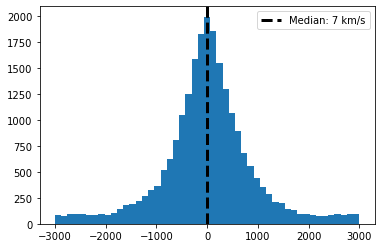

In [141]:
vmask = np.abs(vlos)<=2500.
zm = np.median(vlos[vmask])
_ = plt.hist(vlos,bins=np.linspace(-3000.,3000.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %i km/s'%zm)
plt.legend()

In [142]:
def vcirc(mass,redshift,mdef,cosmo):
    '''Calculate circular velocity in km/s for halos of mass M (Msun/h)'''
    rho_crit = cosmo.critical_density(redshift)
    if mdef[-1] == 'c':
        delta = int(mdef[:-1])
        rho = delta*rho_crit
    elif mdef[-1] == 'm':
        delta = int(mdef[:-1])
        rho = delta*rho_crit*cosmo.Om(redshift)
    else:
        raise RuntimeError("Not correct mass definition")
    v = np.sqrt(G*(np.pi*4*rho/3)**(1./3)*(mass*u.Msun/cosmo.h)**(2./3))
    a = v.to(u.km/u.s)
    return a.value

In [143]:
vc   = vcirc(10**gal['M200'],gal['redshift'],'200c',cosmo)

Text(0.5, 0, '$v_{los}/v_{circ}$')

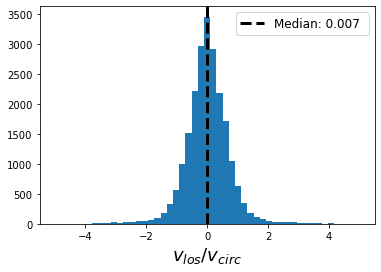

In [144]:
zm = np.median(vlos[vmask]/vc[vmask])

_ = plt.hist(vlos[vmask]/vc[vmask],bins=np.linspace(-5.,5.))
plt.axvline(zm,ls='--',lw=3,color='k',label='Median: %.3f '%zm)
plt.legend(fontsize=12)
plt.xlabel(r'$v_{los}/v_{circ}$',fontsize=18)

In [145]:
gal['vlos'] = vlos
gal['vlosn']= vlos/vc

In [146]:
vlosn = vlos/vc
rnorm = gal['Rn']

cut = np.abs(vlosn)<2.1

# Orbital Classification
---------------------------------------


Here we assign the classes, orbital, infall and interloper.

In [147]:
from sklearn.ensemble import RandomForestClassifier
import joblib
loaded_rf = joblib.load("/Users/jesteves/Downloads/phase_space/classification_2d_rf.joblib")

/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/usr/local/anaconda/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [148]:
import pandas as pd
df   = pd.DataFrame ({ 'r2d':rnorm, 'vlos':vlosn})
tags = loaded_rf.predict(df) 


In [149]:
tag_probability = loaded_rf.predict_proba(df) 

In [150]:
tag_probability

array([[0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [0.14, 0.78, 0.08],
       ...,
       [0.03, 0.82, 0.15],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ]])

In [151]:
def get_random_assignment(prob):
    is_class = np.full(len(prob),0)
    for i,pi in enumerate(prob):
        is_class[i] = int(pi>np.random.random())
    return is_class

In [152]:
porbital= tag_probability[:,0]
pinfall = tag_probability[:,1]
pinterl = tag_probability[:,2]

orbital = get_random_assignment(porbital)
infall  = get_random_assignment(pinfall)
interl  = get_random_assignment(pinterl)

Text(0.5, 0, 'Probability')

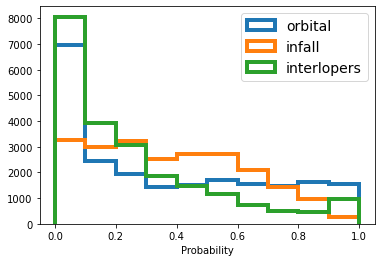

In [153]:
plt.hist(porbital[cut],histtype='step',lw=4,label='orbital')
plt.hist(pinfall[cut],histtype='step',lw=4,label='infall')
plt.hist(pinterl[cut],histtype='step',lw=4,label='interlopers')
plt.legend(fontsize=14)
plt.xlabel('Probability')

In [154]:
# np.count_nonzero(orbital)/len(orbital)
# np.count_nonzero(infall)/len(orbital)
np.count_nonzero(interl)/len(orbital)

0.5917637841543434

In [155]:
gal['infall']     = infall 
gal['orbital']    = orbital
gal['interloper'] = interl

gal['pinfall']     = pinfall 
gal['porbital']    = porbital
gal['pinterloper'] = pinterl

In [156]:
import seaborn as sns
sns.set_context('notebook')

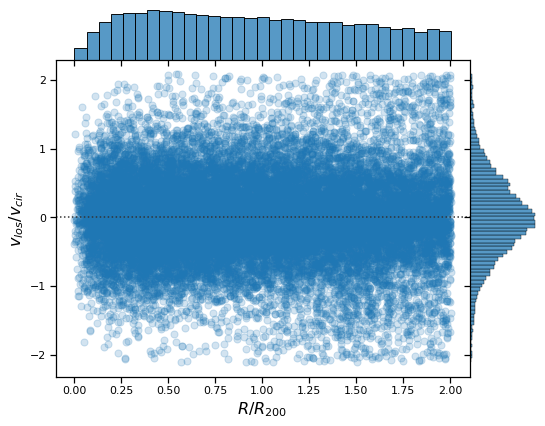

In [157]:
# ax = sns.jointplot(x=rnorm[cut], y=vlos[cut], kind="scatter", s=10, alpha=0.3, space=0)
# ax = sns.jointplot(x=rnorm[cut], y=vlos[cut], kind="resid", space=0, height=6, ratio=6, joint_kws = {'scatter_kws':dict(alpha=0.2,s=50)},ylim=(-1650,1650))
ax = sns.jointplot(x=rnorm[cut], y=vlosn[cut], kind="resid", space=0, height=6, ratio=6, joint_kws = {'scatter_kws':dict(alpha=0.2,s=50)})
ax.set_axis_labels(r'$R/R_{200}$', r'$v_{los}/v_{cir}$ ', fontsize=16)
ax.fig.set_figwidth(8)

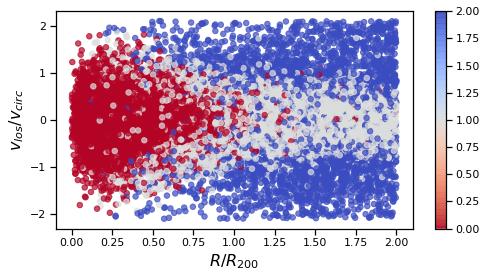

In [158]:
plt.figure(figsize=(8,4))
plt.scatter(rnorm[cut],vlosn[cut],c=tags[cut],alpha=0.7,s=30,cmap='coolwarm_r')
plt.xlabel(r'$R/R_{200}$',fontsize=16)
plt.ylabel(r'$v_{los}/ v_{circ} $',fontsize=16)
plt.colorbar()

# Saving File
---------------------------------------


In [159]:
galaxy_file[:-4]+'_volumeLimited_v1'

'../data/groupCatalog_Yang_deCarvalho2017_galaxy_volumeLimited_v1'

In [161]:
#fl.gal_fname1 = galaxy_file[:-4]+'_v1.csv'
fl.gal_fname1 = galaxy_file[:-4]+'_volumeLimited_v1'
gal.write(fl.gal_fname1,format='csv',overwrite=True)